<a href="https://colab.research.google.com/github/giovanna-bardi12/Classificacao-de-pneumonia-em-imagens-de-RAIO-X/blob/main/interpreta%C3%A7%C3%A3oGRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf

###Interpretabilidade gradCAM

O gradCAM calcula os gradientes das características extraídas na última camada de convolução da rede. Os cálculos são mapeados em cores e sobrepostos na imagem analisada, apresentando visualmente quais regiões o modelo está priorizando em sua tomada de decisão

In [2]:
#drive do ps
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/cv.dataset/Dados - desafio CV/train.zip" .
!cp "/content/drive/MyDrive/cv.dataset/Dados - desafio CV/test_images.zip" .

#unzip
!unzip -o -q train.zip
!unzip -o -q test_images.zip

print("Arquivos extraídos:")
print(os.listdir("."))

Arquivos extraídos:
['.config', 'test_images.zip', 'train.zip', 'train', 'drive', 'test_images', 'sample_data']


In [5]:
from tensorflow.keras.models import load_model

In [6]:
modelo_melhor = load_model('/content/drive/MyDrive/cv.dataset/melhor_modelo.h5')
import cv2

def gerar_grad_cam(img_path, modelo_completo):
    #carregar e processar as imagens novamente
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    vgg16_base = modelo_completo.layers[0]
    camadas_classificador = modelo_completo.layers[1:]

    ultima_camada_conv = 'block5_conv3'
    vgg_model = tf.keras.Model(vgg16_base.inputs, vgg16_base.get_layer(ultima_camada_conv).output)

    with tf.GradientTape() as tape:
        #passa a imagem pela VGG16
        conv_outputs = vgg_model(img_batch)
        tape.watch(conv_outputs)

        #passa a saída da VGG16 pelo resto do modelo
        x = conv_outputs
        for layer in camadas_classificador:
            x = layer(x)
        preds = x #probabilidade final de ser pnumonia

    grads = tape.gradient(preds, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    #normaliar para valores entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img_original = cv2.imread(img_path)
    img_original = cv2.resize(img_original, (224, 224))
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    heatmap_redimensionado = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap_redimensionado = np.uint8(255 * heatmap_redimensionado)
    heatmap_colorido = cv2.applyColorMap(heatmap_redimensionado, cv2.COLORMAP_JET)
    heatmap_colorido = cv2.cvtColor(heatmap_colorido, cv2.COLOR_BGR2RGB)

    imagem_sobreposta = cv2.addWeighted(img_original, 0.6, heatmap_colorido, 0.4, 0)

    return img_original, imagem_sobreposta

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


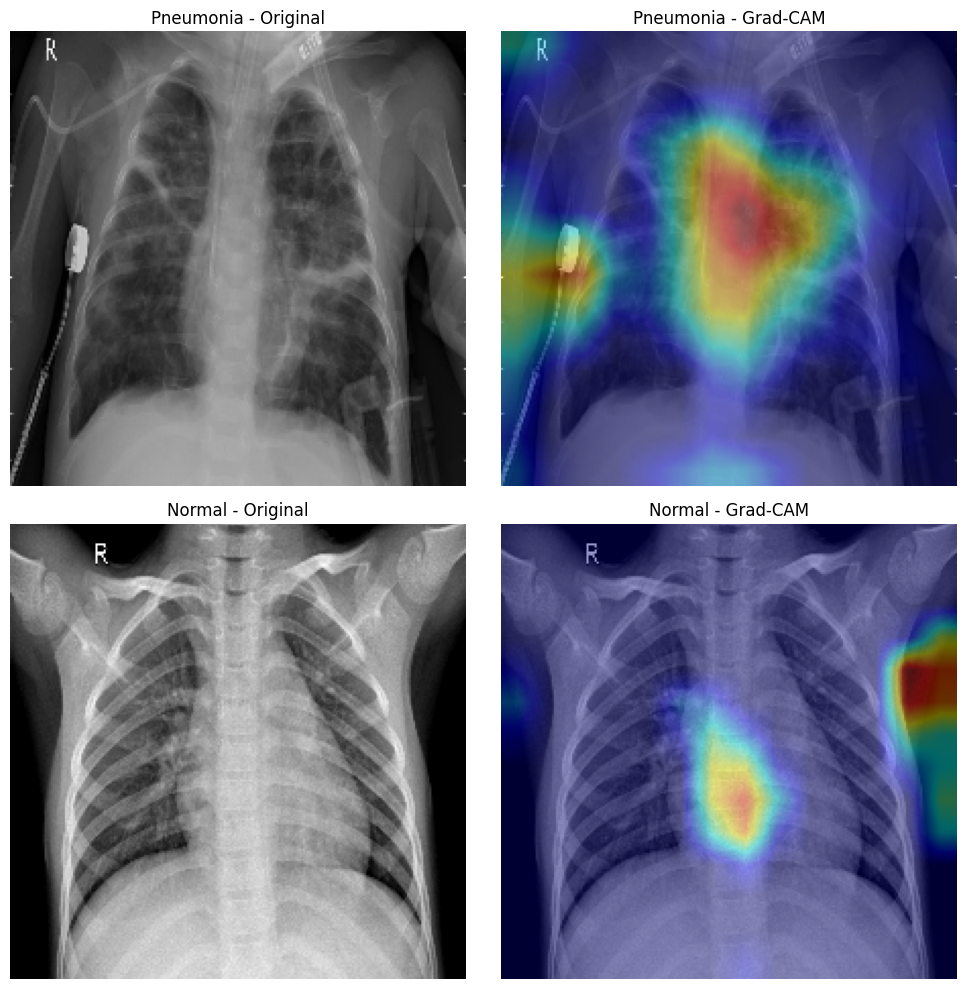

In [7]:
pasta_imagens_normal = 'train/NORMAL'
pasta_imagens_pneumonia = 'train/PNEUMONIA'

#pega uma imagem aleatória em cada página
img_normal_nome = random.choice(os.listdir(pasta_imagens_normal))
img_pneumonia_nome = random.choice(os.listdir(pasta_imagens_pneumonia))

caminho_normal = os.path.join(pasta_imagens_normal, img_normal_nome)
caminho_pneumonia = os.path.join(pasta_imagens_pneumonia, img_pneumonia_nome)

orig_pneu, cam_pneu = gerar_grad_cam(caminho_pneumonia, modelo_melhor)
orig_norm, cam_norm = gerar_grad_cam(caminho_normal, modelo_melhor)

# Plota os resultados
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(orig_pneu)
axes[0, 0].set_title("Pneumonia - Original")
axes[0, 0].axis('off')

axes[0, 1].imshow(cam_pneu)
axes[0, 1].set_title("Pneumonia - Grad-CAM")
axes[0, 1].axis('off')

axes[1, 0].imshow(orig_norm)
axes[1, 0].set_title("Normal - Original")
axes[1, 0].axis('off')

axes[1, 1].imshow(cam_norm)
axes[1, 1].set_title("Normal - Grad-CAM")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Pode-se observar que o modelo mapeia as manchas claras e a opacidade que foi observado em pulmões de pacientes com pneumonia com precisão, sendo essa detecção as partes com colarações de tons quentes. Em contrapartida nas imagens de pacientes saudáveis o modelo não apresenta ativações nessas áreas devido à ausência de anomalias, logo provando a credibilidade do modelo.